This notebook groups the orbits into smaller categories rather than 5 broad categories

# Satellite Orbits
The data used in this analysis Joint Spectrum Center Equipment, Tactical, Space (JETS) database. The complete data set contained 55 data fields and 9539 satellite records. The majority of the records did not contain orbital parameter data, were duplicates, or were labeled as "dummy" or "filler data". The data set was cleaned to remove those records as well as all CUI data. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from six import StringIO  
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydot
from IPython.display import Image

sns.set_theme(style='darkgrid')

The goal of this project is to predict the Orbit Type from other satellite data. 

Load data  

In [2]:
df = pd.read_csv('data/satellites.csv',index_col='Index')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1024 entries, 22 to 9533
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Inclination Angle (deg)                  1024 non-null   float64
 1   Right Ascension of Ascending Node (deg)  1024 non-null   float64
 2   Eccentricity                             1024 non-null   float64
 3   Argument of Perigee (deg)                1024 non-null   float64
 4   Mean Anomaly (deg)                       1024 non-null   float64
 5   Mean Motion (revs/day)                   1024 non-null   float64
 6   Orbit Type                               1024 non-null   object 
dtypes: float64(6), object(1)
memory usage: 64.0+ KB


In [3]:
df.describe(include='all').transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Inclination Angle (deg),1024.0,NaN,NaN,NaN,48.88102,40.270188,0.0027,1.94785,52.0071,86.4468,143.4659
Right Ascension of Ascending Node (deg),1024.0,NaN,NaN,NaN,172.108589,102.414991,0.1472,75.33285,175.8471,259.848675,359.6573
Eccentricity,1024.0,NaN,NaN,NaN,0.038881,0.155641,0.000004,0.000235,0.000428,0.001773,0.971837
Argument of Perigee (deg),1024.0,NaN,NaN,NaN,160.889449,100.884587,0.1486,78.42075,145.72915,250.563775,359.9245
Mean Anomaly (deg),1024.0,NaN,NaN,NaN,190.083795,97.264927,0.1621,113.116275,195.37945,274.185025,359.99
Mean Motion (revs/day),1024.0,NaN,NaN,NaN,7.877526,6.513565,0.068866,1.002715,12.383191,14.342198,16.236741
Orbit Type,1024,17,S4G,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN


View the target data (Orbit Type)

In [4]:
print(df['Orbit Type'].value_counts())

Orbit Type
S4G    245
S42    223
S45    194
S43     91
S4A     85
S4I     70
S4J     43
S4K     28
S4V     11
S4H      9
S46      5
S4E      5
S4D      4
S44      4
S4M      3
S4W      3
S4C      1
Name: count, dtype: int64


The the classes are imbalanced, it may be possible to adjust the classes into broader groups.

### Explore grouping Orbit Types

In [5]:
orbit_codes = pd.read_csv('data/orbit_codes.csv')
orbit_codes = pd.DataFrame(df['Orbit Type'].value_counts()).merge(orbit_codes,on='Orbit Type')
orbit_codes

,Orbit Type,count,Orbit Name
0,S4G,245,GEO STATIONARY
1,S42,223,LEO SUN-SYNCHRONOUS
2,S45,194,LEO INTERMEDIATE
3,S43,91,LEO POLAR
4,S4A,85,MEO
5,S4I,70,GEO INCLINED DRIFT
6,S4J,43,GEO INCLINED
7,S4K,28,HIGHLY ELLIPTIC (HEO)
8,S4V,11,DEEP ECCENTRIC
9,S4H,9,GEO DRIFT


**Other or Deep Space**  
Non-GEO, Deep Space, Deep Eccentric    (14)    

**HEO**   
Molniya, HEO    (30)    

**LEO**  
sun-sync  223  
intermediate  194  
polar  91  

retrograde  5  
equatorial  4    

**MEO**  
MEO (85)  

**GEO**  
stationary  245

inclined drift  70  
geo inclined  43  

drift  9

synchronous   5  
near-synchronous   4  




Look at several scatter plots with the Orbits identified to help determine how to group

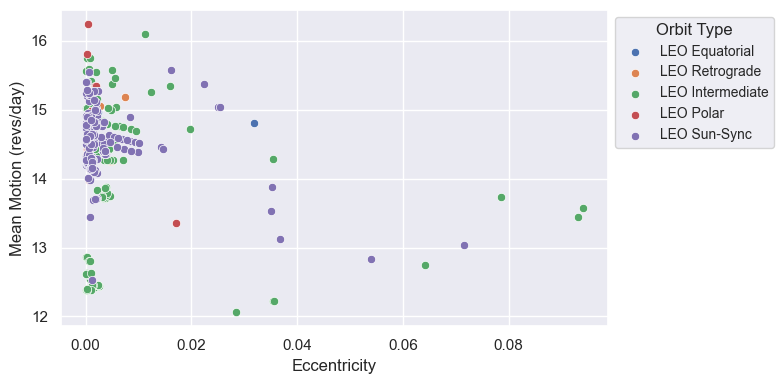

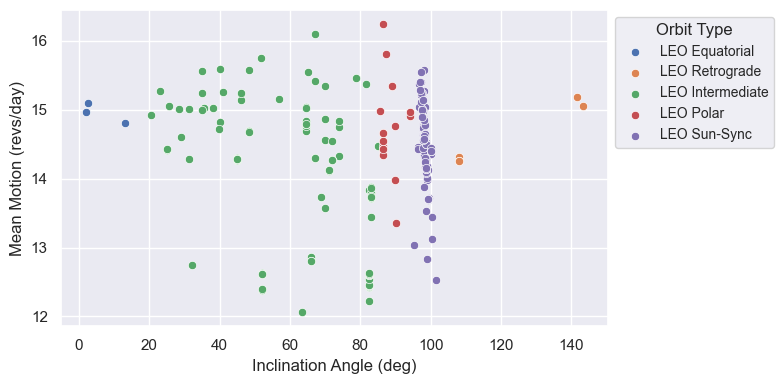

In [6]:
xfield = 'Eccentricity'
yfield = 'Mean Motion (revs/day)'

fig,ax = plt.subplots(figsize=(8,4))

sns.scatterplot(data=df[df['Orbit Type']=='S44'], x=xfield, y=yfield, ax=ax, label='LEO Equatorial')
sns.scatterplot(data=df[df['Orbit Type']=='S46'], x=xfield, y=yfield, ax=ax, label='LEO Retrograde')
sns.scatterplot(data=df[df['Orbit Type']=='S45'], x=xfield, y=yfield, ax=ax, label='LEO Intermediate')
sns.scatterplot(data=df[df['Orbit Type']=='S43'], x=xfield, y=yfield, ax=ax, label='LEO Polar')
sns.scatterplot(data=df[df['Orbit Type']=='S42'], x=xfield, y=yfield, ax=ax, label='LEO Sun-Sync')

ax.legend(fontsize=10,title='Orbit Type',bbox_to_anchor=(1,1),loc='upper left')
fig.tight_layout()

xfield = 'Inclination Angle (deg)'
yfield = 'Mean Motion (revs/day)'

fig,ax = plt.subplots(figsize=(8,4))

sns.scatterplot(data=df[df['Orbit Type']=='S44'], x=xfield, y=yfield, ax=ax, label='LEO Equatorial')
sns.scatterplot(data=df[df['Orbit Type']=='S46'], x=xfield, y=yfield, ax=ax, label='LEO Retrograde')
sns.scatterplot(data=df[df['Orbit Type']=='S45'], x=xfield, y=yfield, ax=ax, label='LEO Intermediate')
sns.scatterplot(data=df[df['Orbit Type']=='S43'], x=xfield, y=yfield, ax=ax, label='LEO Polar')
sns.scatterplot(data=df[df['Orbit Type']=='S42'], x=xfield, y=yfield, ax=ax, label='LEO Sun-Sync')

ax.legend(fontsize=10,title='Orbit Type',bbox_to_anchor=(1,1),loc='upper left')
fig.tight_layout()



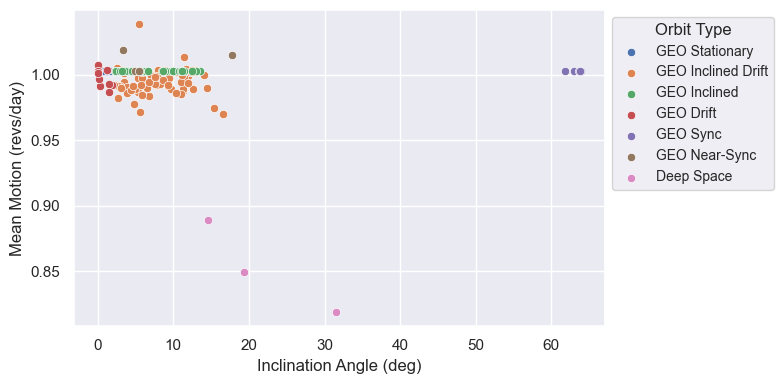

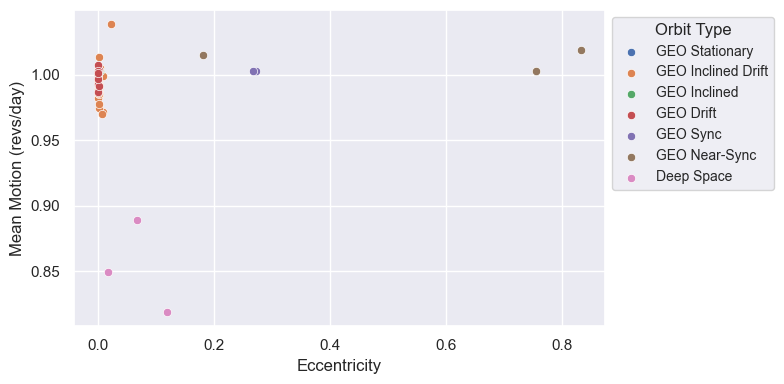

In [7]:
xfield = 'Inclination Angle (deg)'
yfield = 'Mean Motion (revs/day)'

fig,ax = plt.subplots(figsize=(8,4))

sns.scatterplot(data=df[df['Orbit Type']=='S4G'], x=xfield, y=yfield, ax=ax, label='GEO Stationary')
sns.scatterplot(data=df[df['Orbit Type']=='S4I'], x=xfield, y=yfield, ax=ax, label='GEO Inclined Drift')
sns.scatterplot(data=df[df['Orbit Type']=='S4J'], x=xfield, y=yfield, ax=ax, label='GEO Inclined')
sns.scatterplot(data=df[df['Orbit Type']=='S4H'], x=xfield, y=yfield, ax=ax, label='GEO Drift')
sns.scatterplot(data=df[df['Orbit Type']=='S4E'], x=xfield, y=yfield, ax=ax, label='GEO Sync')
sns.scatterplot(data=df[df['Orbit Type']=='S4D'], x=xfield, y=yfield, ax=ax, label='GEO Near-Sync')
sns.scatterplot(data=df[df['Orbit Type']=='S4W'], x=xfield, y=yfield, ax=ax, label='Deep Space')

ax.legend(fontsize=10,title='Orbit Type',bbox_to_anchor=(1,1),loc='upper left')
fig.tight_layout()
xfield = 'Eccentricity'
yfield = 'Mean Motion (revs/day)'

fig,ax = plt.subplots(figsize=(8,4))

sns.scatterplot(data=df[df['Orbit Type']=='S4G'], x=xfield, y=yfield, ax=ax, label='GEO Stationary')
sns.scatterplot(data=df[df['Orbit Type']=='S4I'], x=xfield, y=yfield, ax=ax, label='GEO Inclined Drift')
sns.scatterplot(data=df[df['Orbit Type']=='S4J'], x=xfield, y=yfield, ax=ax, label='GEO Inclined')
sns.scatterplot(data=df[df['Orbit Type']=='S4H'], x=xfield, y=yfield, ax=ax, label='GEO Drift')
sns.scatterplot(data=df[df['Orbit Type']=='S4E'], x=xfield, y=yfield, ax=ax, label='GEO Sync')
sns.scatterplot(data=df[df['Orbit Type']=='S4D'], x=xfield, y=yfield, ax=ax, label='GEO Near-Sync')
sns.scatterplot(data=df[df['Orbit Type']=='S4W'], x=xfield, y=yfield, ax=ax, label='Deep Space')

ax.legend(fontsize=10,title='Orbit Type',bbox_to_anchor=(1,1),loc='upper left')
fig.tight_layout()

In [9]:
orbit_classes = {'GEO Stationary': ['S4G', 'S4H'], # stationary and drift 
                 'GEO Inclined': ['S4I', 'S4J','S4E','S4D','S4W'], # inclined and inclined drift and sync/near-sync, deep

                 'LEO Sun-Sync': ['S42'],
                 'LEO Intermediate': ['S45','S44','S46'], # intermediate, retrograde, equatorial
                 'LEO Polar': ['S43'],

                 'MEO': ['S4A'],
                 'HEO': ['S4K','S4M','S4C','S4V'], # heo, molniya, deep eccentric, non-geo
                 }

orb_typ = {}
for key,value in orbit_classes.items():
    for code in value:
        orb_typ[code] = key

In [10]:
df['Orbit'] = df.loc[:,('Orbit Type')].map(orb_typ)
print(df['Orbit'].value_counts())
df_og = df.copy()

Orbit
GEO Stationary      254
LEO Sun-Sync        223
LEO Intermediate    203
GEO Inclined        125
LEO Polar            91
MEO                  85
HEO                  43
Name: count, dtype: int64


In [11]:
# add general orbits
general_orbits = {'GEO':['GEO Stationary','GEO Inclined'], 'HEO':['HEO'],'MEO':['MEO'], 'LEO':['LEO Sun-Sync','LEO Intermediate','LEO Polar']}
gen_orb_typ = {}
for key,value in general_orbits.items():
    for orbit in value:
        gen_orb_typ[orbit] = key
df['GenOrbit'] = df.loc[:,('Orbit')].map(gen_orb_typ)
df_og = df.copy()

In [12]:
orbit_order = ['GEO Stationary','GEO Inclined','HEO','MEO','LEO Sun-Sync','LEO Intermediate','LEO Polar']

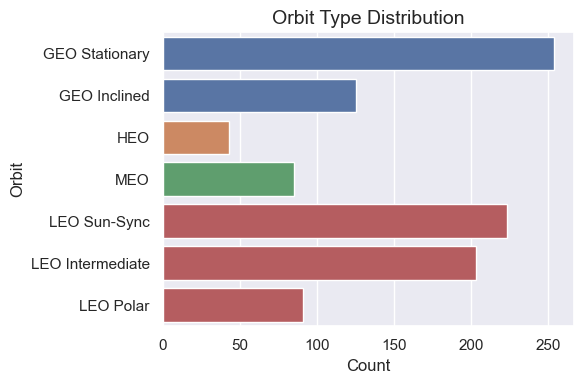

In [25]:
sns.set(font_scale=1.0) 
fig,ax = plt.subplots(figsize=(6,4))
sns.countplot(data=df,y='Orbit',ax=ax, hue='GenOrbit',order=orbit_order,legend=False,hue_order=['GEO','HEO','MEO','LEO'])
ax.set_title('Orbit Type Distribution',fontsize=14)
ax.set_xlabel('Count')
fig.tight_layout()
fig.savefig('orbit_distribution.png',dpi=300)

Look at distributions of other data.

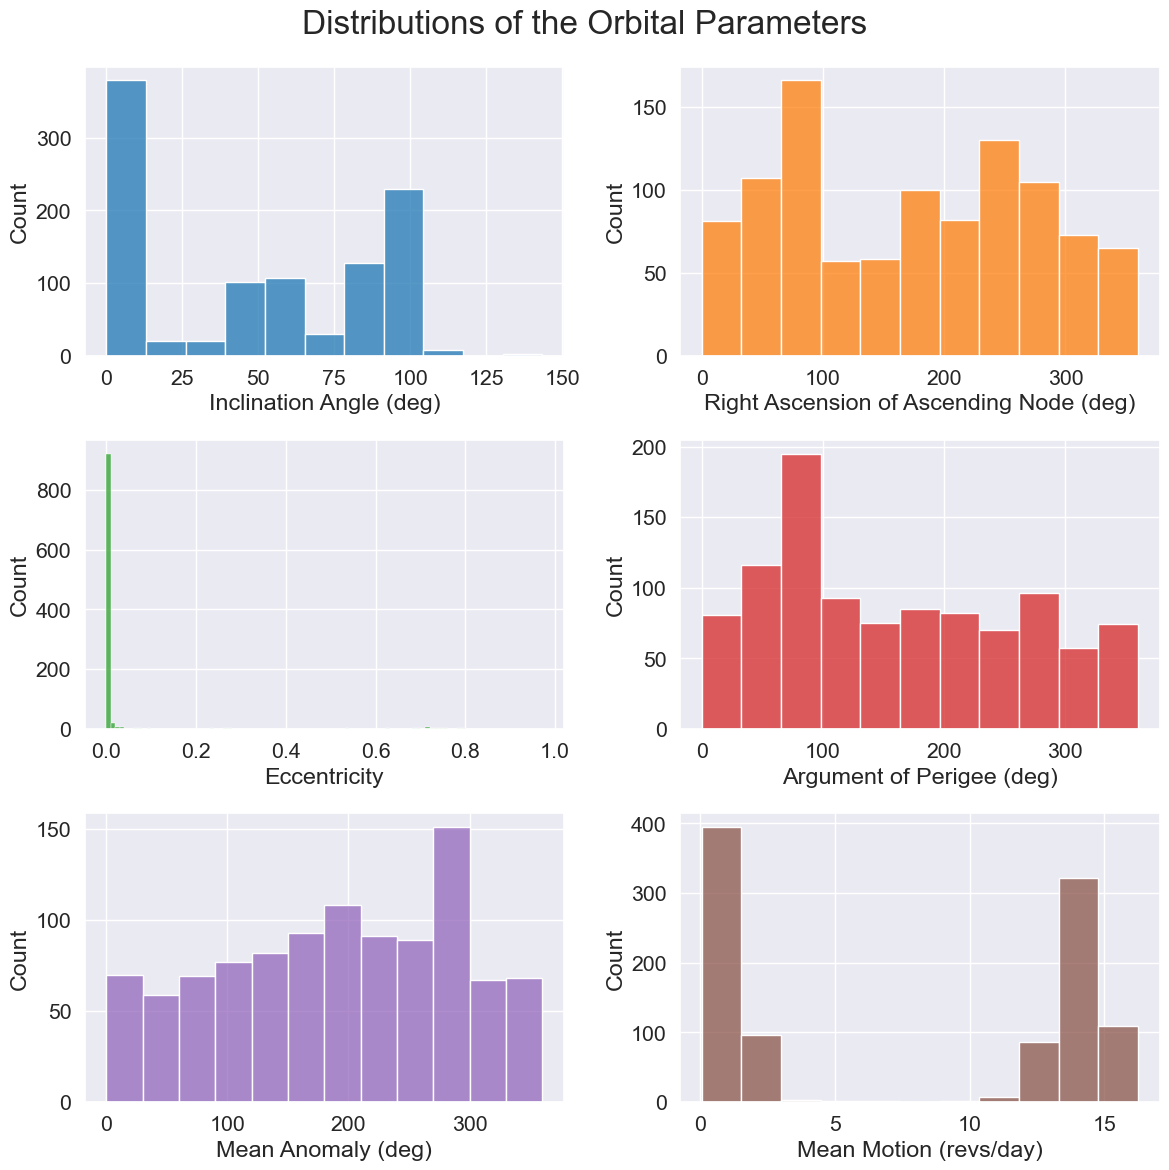

In [15]:
cmap = sns.color_palette('tab10')
sns.set(font_scale=1.4) 

fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(12,12))
for idx, column in enumerate(df.drop(['Orbit Type','Orbit','GenOrbit'],axis=1).columns):
    if column == 'Eccentricity':
        sns.histplot(data=df, x=column, ax=axs.flatten()[idx], color=cmap[idx], binwidth=.01)        
    else:
        sns.histplot(data=df, x=column, ax=axs.flatten()[idx], color=cmap[idx])
fig.suptitle('Distributions of the Orbital Parameters',fontsize=24)
fig.tight_layout()
# fig.savefig('variable_distributions.png',dpi=300)

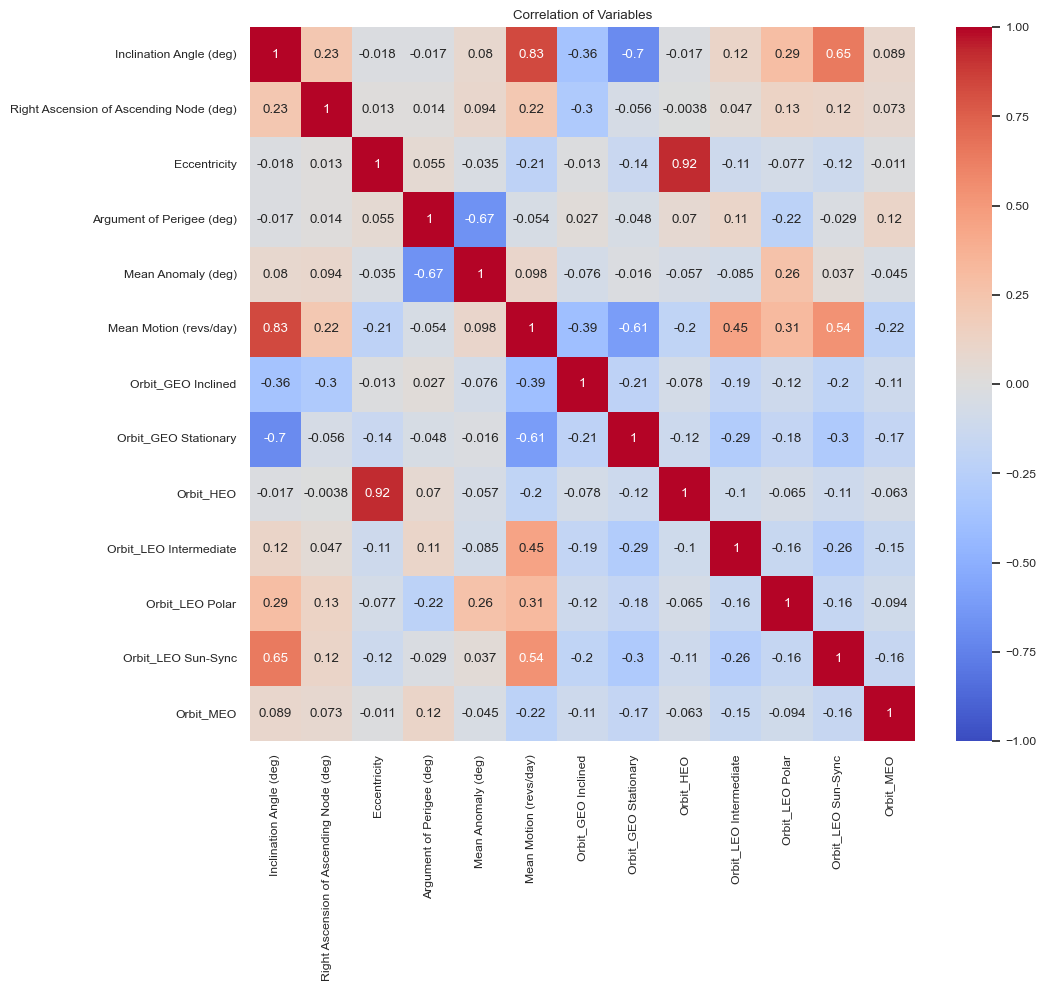

In [16]:
df_ohe = pd.get_dummies(df.drop(columns=['Orbit Type','GenOrbit']), drop_first=False, dtype=int)
sns.set(font_scale=.8) 
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(df_ohe.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
ax.set_title('Correlation of Variables')
fig.tight_layout()

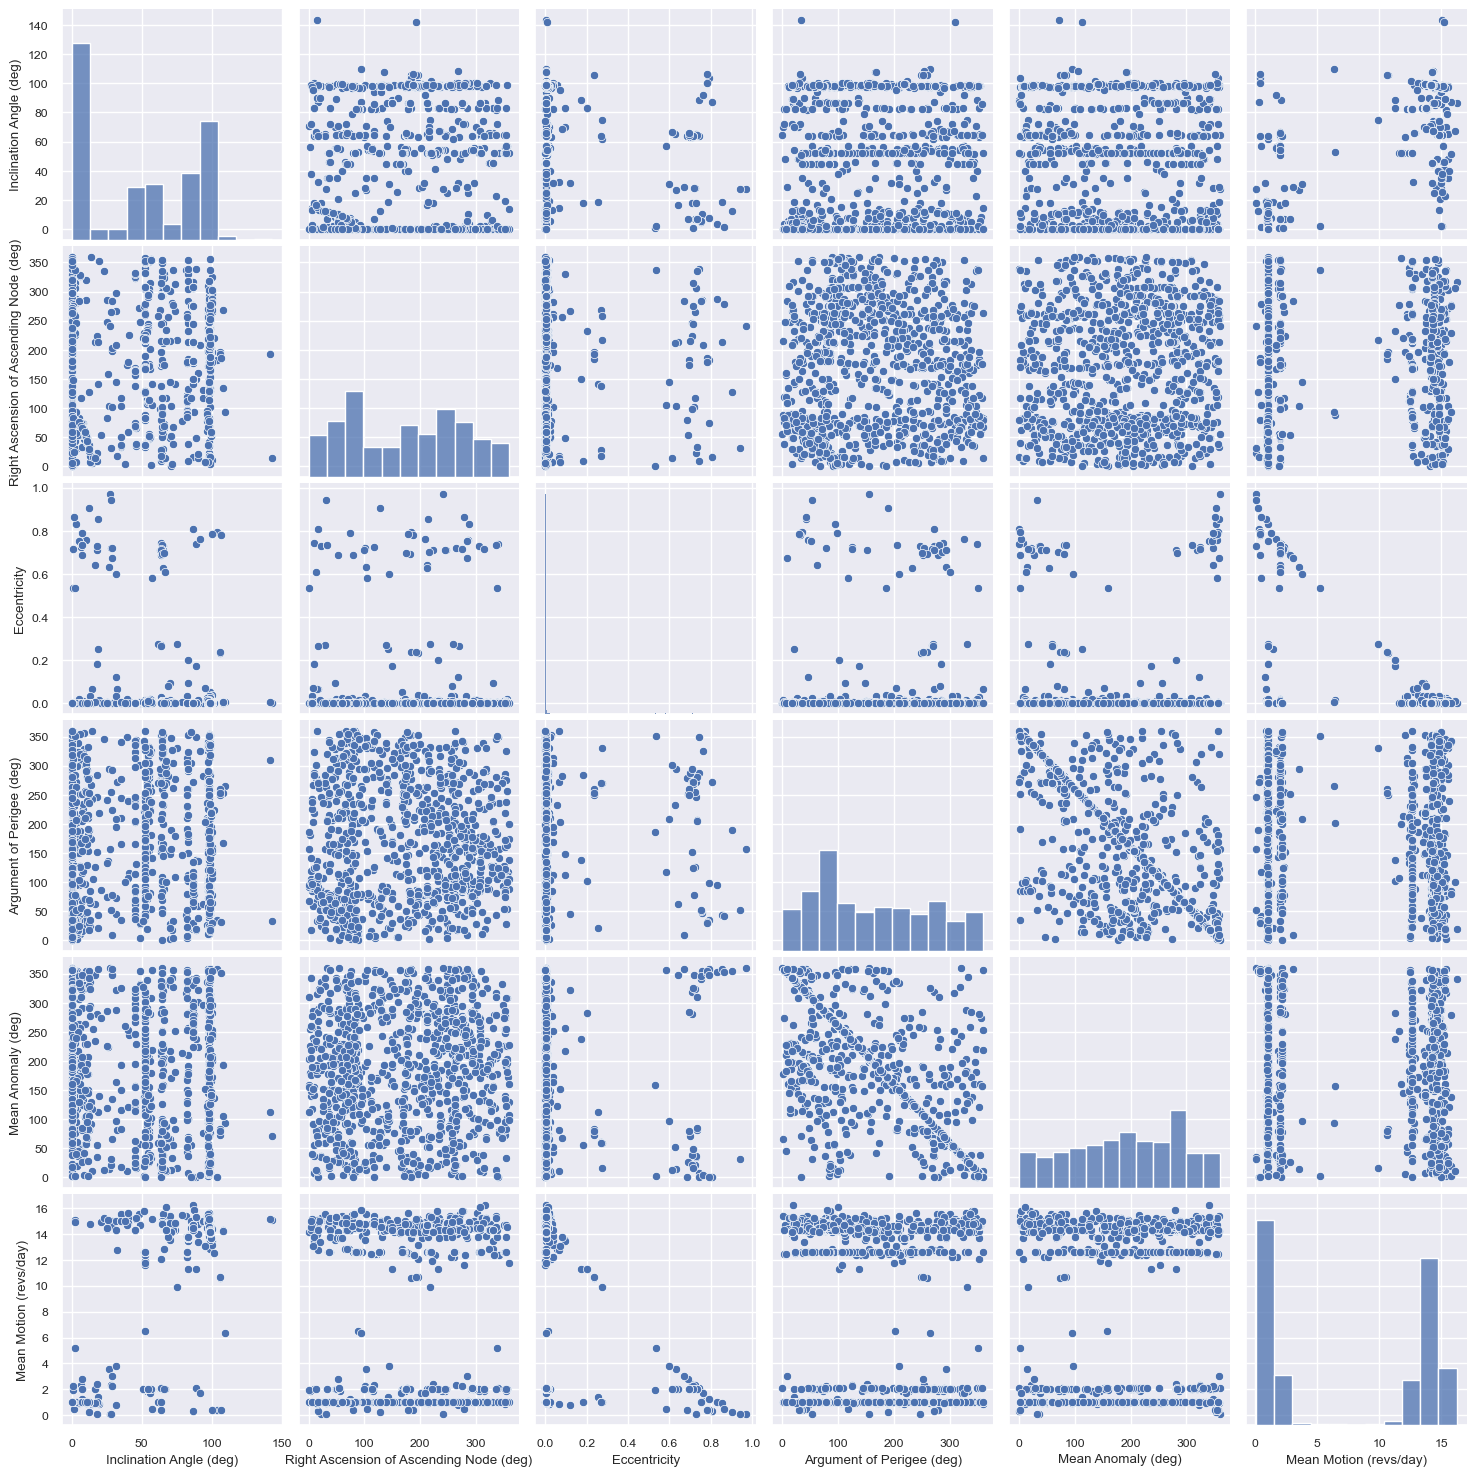

In [17]:
sns.pairplot(df.drop(['Orbit Type','Orbit','GenOrbit'],axis=1))
plt.show()

A few of the scatter plots appear to have some groupings. Some of the most predominant are:
* Eccentricity and Mean Motion
* Eccentricity and Mean Anomaly
* Mean Motion and Inclination
* Mean Motion and Arg Perigee
* Mean Motion and Mean Anomaly

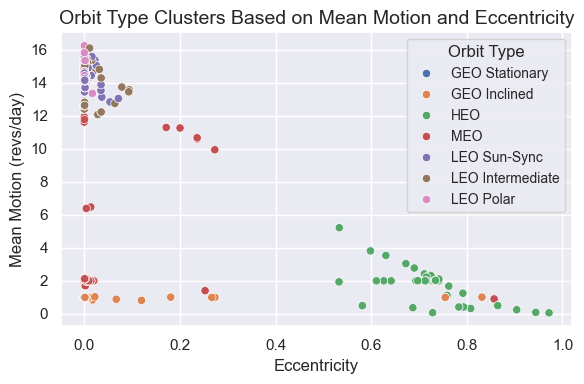

In [24]:
sns.set(font_scale=1.0) 
fig,ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df, x='Eccentricity', y='Mean Motion (revs/day)', ax=ax, hue='Orbit',hue_order=orbit_order)
ax.set_title('Orbit Type Clusters Based on Mean Motion and Eccentricity',fontsize=14)
ax.legend(fontsize=10,title='Orbit Type')
fig.tight_layout()
fig.savefig('images/eccent_mean_motion.png',dpi=300)

## Split Data into Train/Validation/Test

In [26]:


df = df_og.drop(columns=['Orbit Type','GenOrbit']).copy()
X = df.loc[:, df.columns != 'Orbit']
y = df.loc[:, df.columns == 'Orbit']

# Train and Test Split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
# Split Training into Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=49)

print('Train set shape\n',X_train.shape, y_train.shape)
print('Val set shape\n',X_val.shape, y_val.shape)
print('Test set shape\n',X_test.shape, y_test.shape)


Train set shape
 (614, 6) (614, 1)
Val set shape
 (205, 6) (205, 1)
Test set shape
 (205, 6) (205, 1)


---
# Modeling

### Metrics
Plan to use f1, precision, and recall as the primary metrics since the classes are unbalanced, and some classes are more important. The most important orbits to not misidentify are LEO, GEO and HEO. It would be better to mislabel MEOs as LEO or GEO rather than the otherway around. The Deep Space class is the least important.

In [51]:
# these are to view the results of validation or test data
def display_confusion_matrix(y_val,y_pred,label_order=orbit_order):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred,labels=label_order),display_labels=label_order)
    cmp.plot(ax=ax)
    ax.grid(False)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=-45,ha='left')
    fig.tight_layout()

    
def print_classification_report(y_val, y_pred,digits=3,label_order=orbit_order):
    print(classification_report(y_val, y_pred,digits=digits,labels=label_order))

## Trivial Model
### Always Predict Majority Class (GEO Stationary)

C:\Users\richard.peterson\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\richard.peterson\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\richard.peterson\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

                  precision    recall  f1-score   support

  GEO Stationary      0.200     1.000     0.333        41
    GEO Inclined      0.000     0.000     0.000        31
             HEO      0.000     0.000     0.000        10
             MEO      0.000     0.000     0.000        23
    LEO Sun-Sync      0.000     0.000     0.000        42
LEO Intermediate      0.000     0.000     0.000        38
       LEO Polar      0.000     0.000     0.000        20

        accuracy                          0.200       205
       macro avg      0.029     0.143     0.048       205
    weighted avg      0.040     0.200     0.067       205



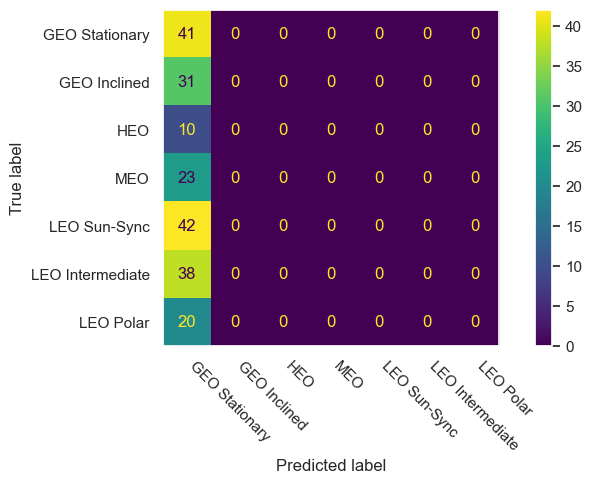

In [52]:
y_pred_maj = ['GEO Stationary']*len(y_val)

display_confusion_matrix(y_val,y_pred_maj)
print_classification_report(y_val,y_pred_maj)

### Randomly Predict Class

                  precision    recall  f1-score   support

  GEO Stationary      0.259     0.171     0.206        41
    GEO Inclined      0.304     0.226     0.259        31
             HEO      0.114     0.400     0.178        10
             MEO      0.125     0.174     0.145        23
    LEO Sun-Sync      0.226     0.167     0.192        42
LEO Intermediate      0.133     0.105     0.118        38
       LEO Polar      0.148     0.200     0.170        20

        accuracy                          0.180       205
       macro avg      0.187     0.206     0.181       205
    weighted avg      0.203     0.180     0.183       205



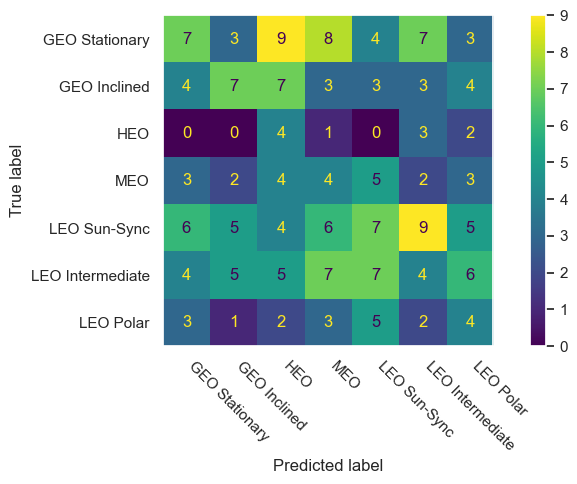

In [53]:
y_pred_rand = np.random.choice(df['Orbit'].unique(),replace=True,size=len(y_val))

display_confusion_matrix(y_val,y_pred_rand)
print_classification_report(y_val,y_pred_rand)

## Classical Modeling

### Logistic Regression


C:\Users\richard.peterson\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                  precision    recall  f1-score   support

  GEO Stationary      0.976     1.000     0.988        41
    GEO Inclined      1.000     1.000     1.000        31
             HEO      1.000     0.800     0.889        10
             MEO      0.957     0.957     0.957        23
    LEO Sun-Sync      0.955     1.000     0.977        42
LEO Intermediate      1.000     0.868     0.930        38
       LEO Polar      0.833     1.000     0.909        20

        accuracy                          0.961       205
       macro avg      0.960     0.946     0.950       205
    weighted avg      0.965     0.961     0.961       205



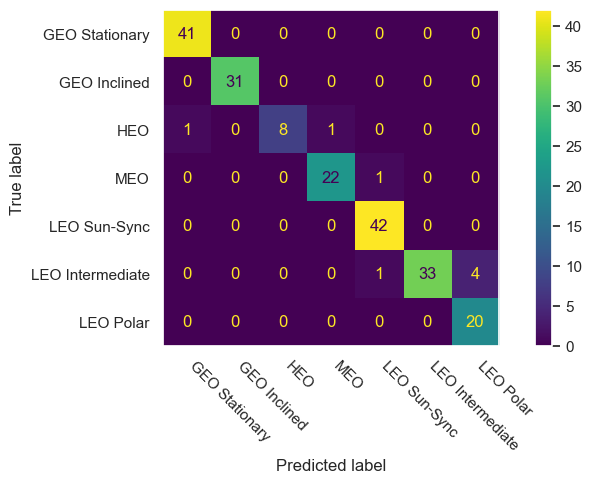

In [54]:
clf_log = LogisticRegression(max_iter=100000).fit(X_train,y_train.values.ravel())

y_pred_log = clf_log.predict(X_val)

display_confusion_matrix(y_val,y_pred_log)
print_classification_report(y_val,y_pred_log)

#### Scale data 

                  precision    recall  f1-score   support

  GEO Stationary      0.695     1.000     0.820        41
    GEO Inclined      1.000     0.419     0.591        31
             HEO      1.000     1.000     1.000        10
             MEO      1.000     0.913     0.955        23
    LEO Sun-Sync      0.840     1.000     0.913        42
LEO Intermediate      0.973     0.947     0.960        38
       LEO Polar      0.933     0.700     0.800        20

        accuracy                          0.863       205
       macro avg      0.920     0.854     0.863       205
    weighted avg      0.895     0.863     0.852       205



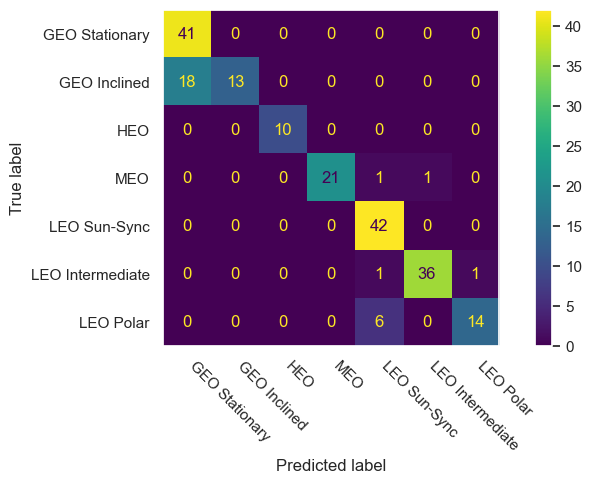

In [55]:
scaler = StandardScaler()
X_train_scl = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_val_scl = pd.DataFrame(scaler.transform(X_val),columns=X_val.columns)

clf_log_scl = LogisticRegression().fit(X_train_scl,y_train.values.ravel())
y_pred_log_scl = clf_log_scl.predict(X_val_scl)

display_confusion_matrix(y_val,y_pred_log_scl)
print_classification_report(y_val,y_pred_log_scl)

In [56]:
clf_log_scl.n_iter_

array([82])

The model converged in just 82 iterations, but the performance decreased.

#### Select Features based on the coefficient magnitudes

In [57]:
dict(zip(clf_log.feature_names_in_,np.round(np.mean(np.abs(clf_log.coef_),axis=0),decimals=2)))

{'Inclination Angle (deg)': 0.61,
 'Right Ascension of Ascending Node (deg)': 0.0,
 'Eccentricity': 1.12,
 'Argument of Perigee (deg)': 0.02,
 'Mean Anomaly (deg)': 0.02,
 'Mean Motion (revs/day)': 1.47}

                  precision    recall  f1-score   support

  GEO Stationary      0.976     1.000     0.988        41
    GEO Inclined      1.000     1.000     1.000        31
             HEO      1.000     0.900     0.947        10
             MEO      1.000     0.957     0.978        23
    LEO Sun-Sync      0.977     1.000     0.988        42
LEO Intermediate      0.972     0.921     0.946        38
       LEO Polar      0.909     1.000     0.952        20

        accuracy                          0.976       205
       macro avg      0.976     0.968     0.971       205
    weighted avg      0.976     0.976     0.975       205



{'Mean Motion (revs/day)': 1.43,
 'Inclination Angle (deg)': 0.67,
 'Eccentricity': 1.13}

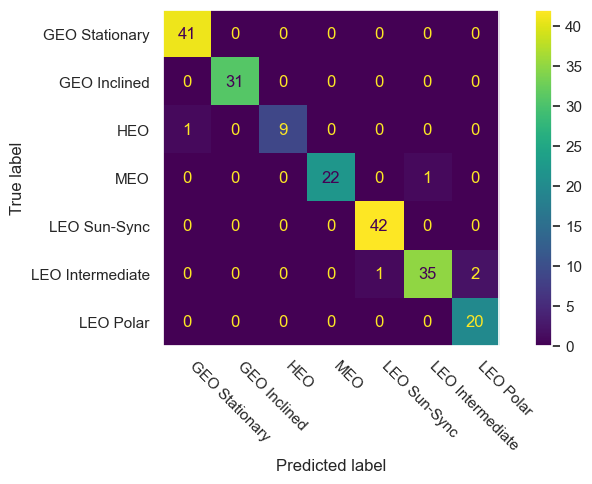

In [58]:
# This was done iteratively to get to the best model performance
features = ['Mean Motion (revs/day)','Inclination Angle (deg)','Eccentricity']
clf_log_sf = LogisticRegression(max_iter=10000).fit(X_train[features],y_train.values.ravel())
y_pred_sf = clf_log_sf.predict(X_val[features])
display_confusion_matrix(y_val,y_pred_sf)
print_classification_report(y_val,y_pred_sf)
dict(zip(clf_log_sf.feature_names_in_,np.round(np.mean(np.abs(clf_log_sf.coef_),axis=0),decimals=2)))

In [59]:
clf_log_sf.n_iter_

array([2601])

The best linear regression model used just 3 features.

### Decision Tree

In [60]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

                  precision    recall  f1-score   support

  GEO Stationary      0.976     1.000     0.988        41
    GEO Inclined      0.969     1.000     0.984        31
             HEO      1.000     0.700     0.824        10
             MEO      0.885     1.000     0.939        23
    LEO Sun-Sync      1.000     1.000     1.000        42
LEO Intermediate      1.000     0.947     0.973        38
       LEO Polar      1.000     1.000     1.000        20

        accuracy                          0.976       205
       macro avg      0.976     0.950     0.958       205
    weighted avg      0.978     0.976     0.975       205



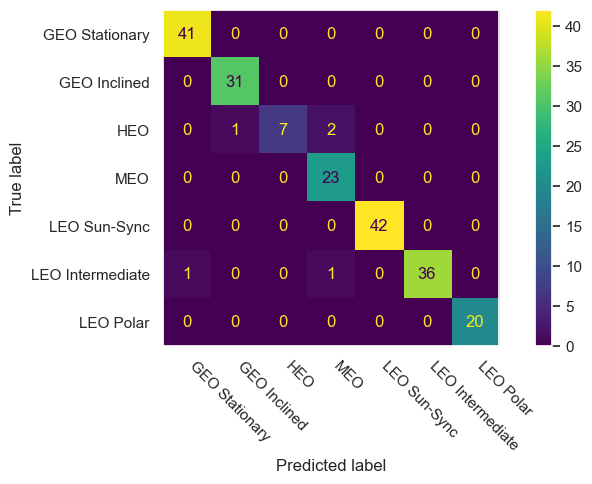

In [63]:
clf_dt = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_val)

display_confusion_matrix(y_val,y_pred_dt)
print_classification_report(y_val,y_pred_dt)

View Decision Tree

In [64]:
d_tree, = print_tree(clf_dt, features=clf_dt.feature_names_in_,class_names=clf_dt.classes_)
Image(d_tree.create_png())

FileNotFoundError: [WinError 2] "dot" not found in path.

In [65]:
dict(zip(clf_dt.feature_names_in_,clf_dt.feature_importances_))

{'Inclination Angle (deg)': 0.6758107563299314,
 'Right Ascension of Ascending Node (deg)': 0.0,
 'Eccentricity': 0.06318182011267774,
 'Argument of Perigee (deg)': 0.0,
 'Mean Anomaly (deg)': 0.0,
 'Mean Motion (revs/day)': 0.26100742355739076}

Only three features were used: Mean Motion, Eccentricity, and Inclination

#### Reduce Features to Confirm

                  precision    recall  f1-score   support

  GEO Stationary      0.976     1.000     0.988        41
    GEO Inclined      0.969     1.000     0.984        31
             HEO      1.000     0.700     0.824        10
             MEO      0.885     1.000     0.939        23
    LEO Sun-Sync      1.000     1.000     1.000        42
LEO Intermediate      1.000     0.947     0.973        38
       LEO Polar      1.000     1.000     1.000        20

        accuracy                          0.976       205
       macro avg      0.976     0.950     0.958       205
    weighted avg      0.978     0.976     0.975       205



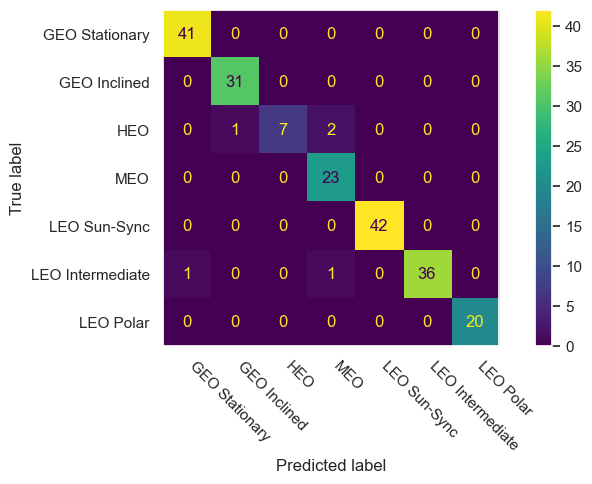

In [66]:
features = ['Mean Motion (revs/day)','Inclination Angle (deg)','Eccentricity']
clf_dt_simple = DecisionTreeClassifier().fit(X_train[features], y_train)
y_pred_dt_simple = clf_dt_simple.predict(X_val[features])

display_confusion_matrix(y_val,y_pred_dt_simple)
print_classification_report(y_val,y_pred_dt_simple)

In [67]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(), params, verbose=1, cv=3)

print(grid_search_cv.fit(X_train, y_train))

Fitting 3 folds for each of 294 candidates, totalling 882 fits
GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)


In [68]:
print(grid_search_cv.best_estimator_)

DecisionTreeClassifier(max_leaf_nodes=39, min_samples_split=3)


## Neural Network

1. Justify your selection of optimization algorithm, loss function and regularization technique, based on the type of problem you are modeling (see concept map on slide 8 of 6B Optimization.pptx).
2. Document how you monitor to prevent overfitting, such as a train/validate split, or cross-validation. Justify your selection, based on your number of datapoints and number of input variables.
3. Perform a hyperparameter sweep on neurons per layer, number of layers and 2 other hyperparameters. Select the model with the best performance.  
4. Investigate how 1 regularization technique affects your modeling, and document the results.
5. Select a “best” model and create a figure that shows the NN did not overfit while training (train/test metric vs epochs).
6. Create a table (similar to part 7d) that summarizes the performance of part 8c/8d NN 3 variations. 

1.  
    * Optimization algorithm: adam or Stochastic Gradient Descent (shallow networks)
    * Loss Function: Cross-entropy (3+ classification)
    * Regularization Technique:   

2. Cross-validation

In [67]:
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

ModuleNotFoundError: No module named 'tensorflow'

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow[and-cuda] (from versions: none)
ERROR: No matching distribution found for tensorflow[and-cuda]


In [ ]:
# create dummy variables for orbits
encoder = LabelEncoder().fit(y_trainval.values.ravel())
y_trainval_encoded = encoder.transform(y_trainval.values.ravel())
y_trainval_dummy = np_utils.to_categorical(y_trainval_encoded)

X_trainval_array = np.array(X_trainval)

In [ ]:
model = Sequential()
model.add(Dense(12,input_dim=X_trainval.shape[1],activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(len(orbit_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_trainval_array,y_trainval_dummy,validation_split=0.25,epochs=100)
_,accuracy = model.evaluate(X_trainval_array,y_trainval_dummy)


Epoch 1/100
20/20 [==============================] - 1s 15ms/step - loss: 48.8658 - accuracy: 0.0651 - val_loss: 31.9352 - val_accuracy: 0.1317
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 21.9626 - accuracy: 0.1906 - val_loss: 12.9934 - val_accuracy: 0.3463
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 11.1050 - accuracy: 0.4593 - val_loss: 8.8635 - val_accuracy: 0.5024
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 7.8962 - accuracy: 0.5147 - val_loss: 6.4764 - val_accuracy: 0.5220
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 5.5616 - accuracy: 0.5358 - val_loss: 4.7574 - val_accuracy: 0.5268
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 4.0417 - accuracy: 0.5651 - val_loss: 3.6145 - val_accuracy: 0.5317
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 3.0290 - accuracy: 0.5928 - val_loss: 2.8697 - val_accuracy: 0.6098
Epoch 8

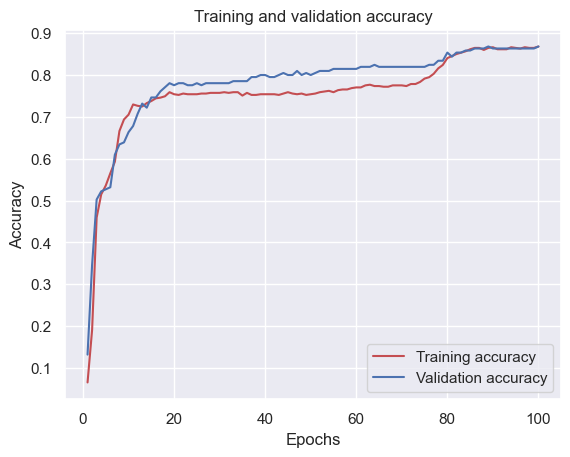

In [ ]:
history_dict = history.history

# learning curve
# accuracy
# acc = history_dict['accuracy']
acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7/7 [==============================] - 0s 3ms/step
[1.7223451e-02 9.7078317e-01 3.0999668e-03 8.8863575e-04 8.0048302e-03]
1.0000001
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.934     1.000     0.966        71
           2      0.500     0.167     0.250         6
           3      0.778     0.980     0.867       100
           4      1.000     0.043     0.083        23

    accuracy                          0.834       205
   macro avg      0.642     0.438     0.433       205
weighted avg      0.830     0.834     0.774       205



C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


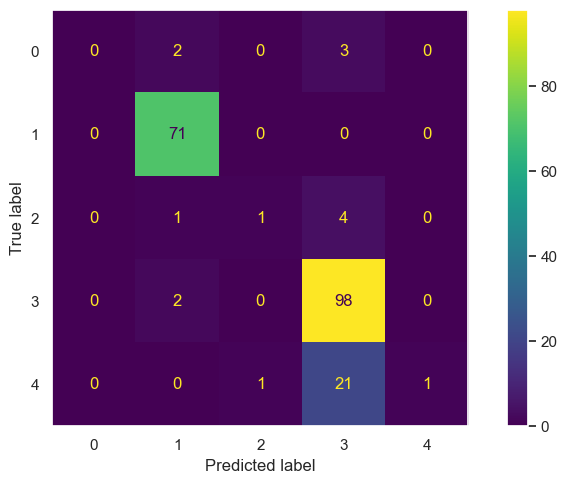

In [ ]:
preds = model.predict(X_val) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1

y_val_encoded = encoder.transform(y_val.values.ravel())
y_pred_NN_encoded = preds.argmax(axis=1)

display_confusion_matrix(y_val_encoded,y_pred_NN_encoded,labels=None)
print_classification_report(y_val_encoded,y_pred_NN_encoded,target_names=None)



In [16]:
print(classification_report(y_val, y_pred))

print(f'{list(zip(model.feature_names_in_,model.feature_importances_))}\n')

                  precision    recall  f1-score   support

    GEO Inclined       1.00      0.97      0.98        30
  GEO Stationary       0.93      1.00      0.97        42
             HEO       1.00      0.70      0.82        10
LEO Intermediate       1.00      0.95      0.97        38
       LEO Polar       1.00      1.00      1.00        20
    LEO Sun-Sync       1.00      1.00      1.00        42
             MEO       0.88      1.00      0.94        23

        accuracy                           0.97       205
       macro avg       0.97      0.94      0.95       205
    weighted avg       0.97      0.97      0.97       205

[('Inclination Angle (deg)', 0.6669768310416123), ('Right Ascension of Ascending Node (deg)', 0.0), ('Eccentricity', 0.09728229869909202), ('Argument of Perigee (deg)', 0.0), ('Mean Anomaly (deg)', 0.0), ('Mean Motion (revs/day)', 0.2357408702592956)]

